In [126]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras

%matplotlib inline

In [127]:
# Get in dataset
data_features_test = pd.read_csv("datasets/energy-informatics-2020/csvDataFeaturesTest.csv", sep=";")

# Take out only data corresponing to attacks and remove the column labelling it as an attack
data_features_attacks = data_features_test.to_numpy()[238279:, :21]
data_features_attacks = data_features_attacks.reshape((9999,21,1)).astype('float32')
data_features_attacks.shape

(9999, 21, 1)

In [128]:
# Batch and shuffle data

train_dataset = (tf.data.Dataset.from_tensor_slices(data_features_attacks[:9000]).shuffle(9000).batch(30))
test_dataset = (tf.data.Dataset.from_tensor_slices(data_features_attacks[9000:]).shuffle(999).batch(30))

data_features_attacks[:9000].shape, data_features_attacks[9000:].shape


((9000, 21, 1), (999, 21, 1))

In [129]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(21, 1)),
            tf.keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu'),
            tf.keras.layers.Conv1D(filters=64, kernel_size=1, activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=21*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(21,32)),
            tf.keras.layers.Conv1DTranspose(filters=64, kernel_size=1, padding='same', activation='relu'),
            tf.keras.layers.Conv1DTranspose(filters=32, kernel_size=1, padding='same', activation='relu'),
            tf.keras.layers.Conv1DTranspose(filters=1, kernel_size=1, padding='same'),
            ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, data):
        mean, logvar = tf.split(self.encoder(data), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterise(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [130]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    s = -0.5 * ((sample-mean) ** 2. * tf.exp(-logvar) + logvar + log2pi)
    return tf.reduce_sum(s, axis=raxis)

def compute_loss(model, data):
    mean, logvar = model.encode(data)
    z = model.reparameterise(mean, logvar)
    data_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=data_logit, labels=data)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

In [131]:
@tf.function
def train_step(model, data, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, data)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [132]:
def predict(model, epoch, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterise(mean, logvar)
    predictions = model.sample(z)
    return predictions

In [133]:

latent_dim = 10
num_examples_to_generate = 29
epochs = int(9000/21)

for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:num_examples_to_generate, :, :]
    print(test_sample.shape)

random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

(29, 21, 1)


In [134]:
predictions = np.array([])
for epoch in range(epochs):
    for train_x in train_dataset:
        train_step(model, train_x, optimizer)
    
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
        loss(compute_loss(model, test_x))
    elbo = -loss.result()

    predictions = np.append(predictions, predict(model, epoch, test_sample))

In [135]:
predictions.shape

(260652,)

In [136]:
size = int(predictions.shape[0]/21)
predictions = predictions.reshape(size, 21)

In [148]:
predictions[:,0]

array([0.26159847, 0.15004078, 0.16257815, ...,        nan,        nan,
              nan])

In [137]:
data_labels = [name for name in data_features_test.columns]

frame_len_actual = data_features_test["frameLen"]
frame_len_generated = predictions[:,0]

/tmp/ipykernel_4208/1291970962.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(i)


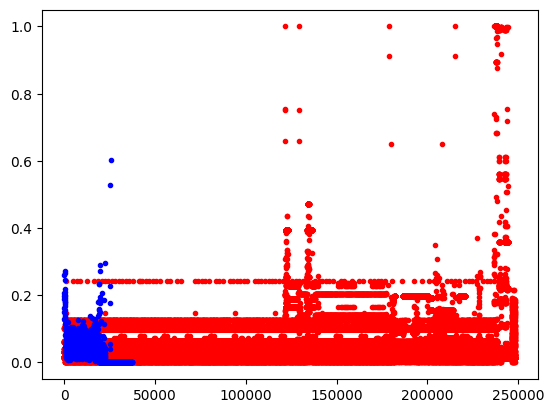

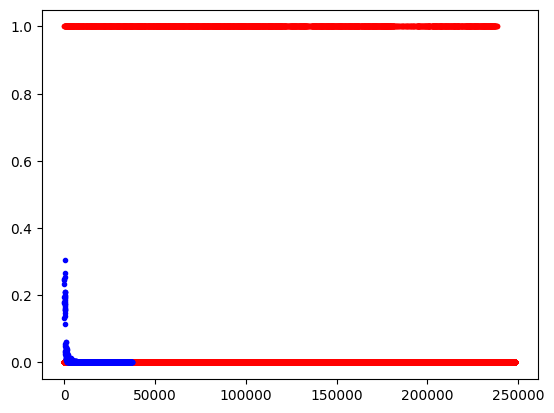

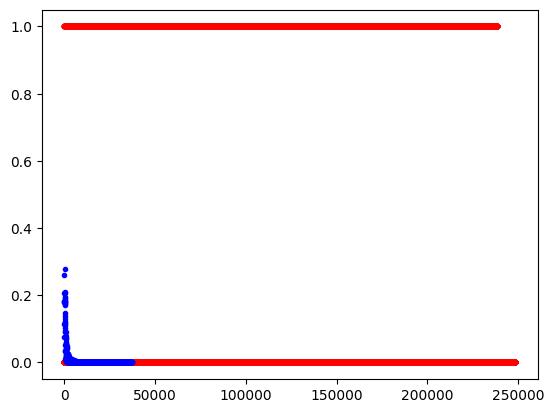

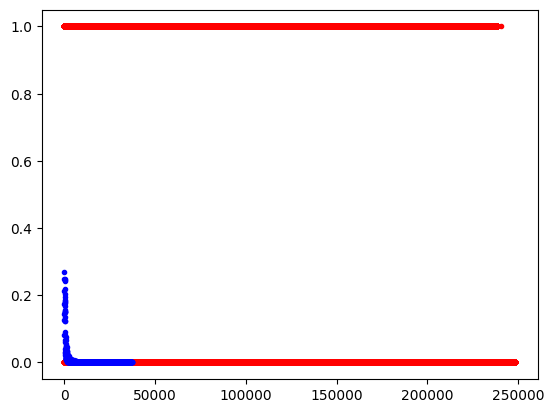

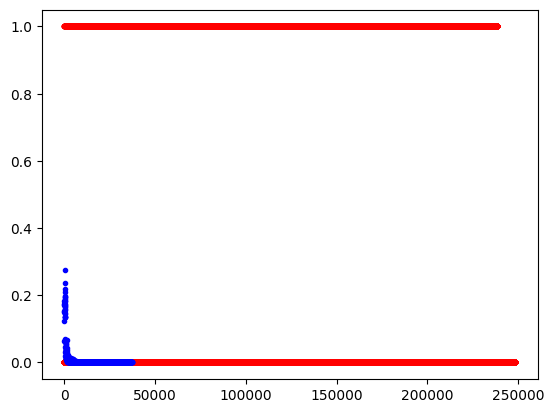

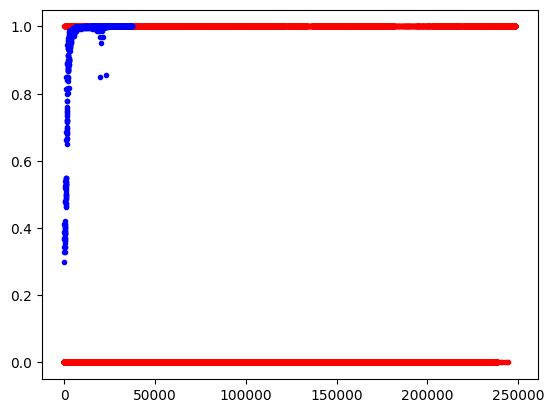

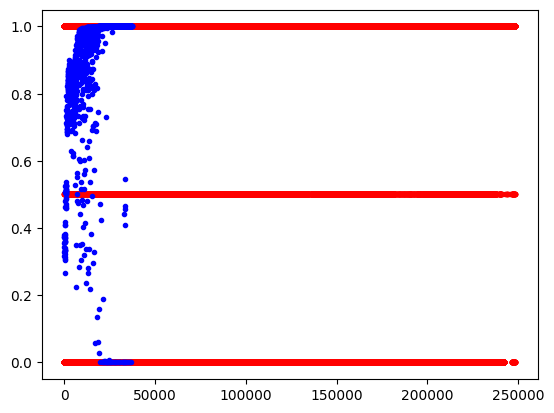

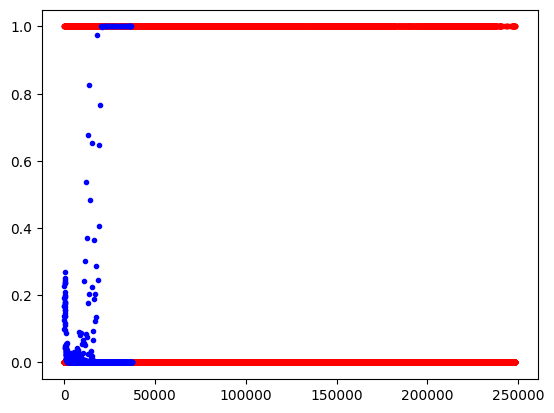

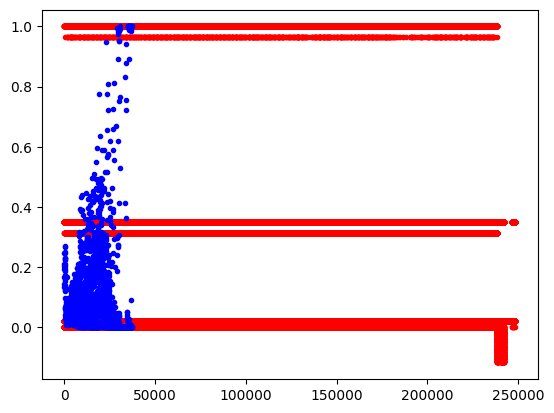

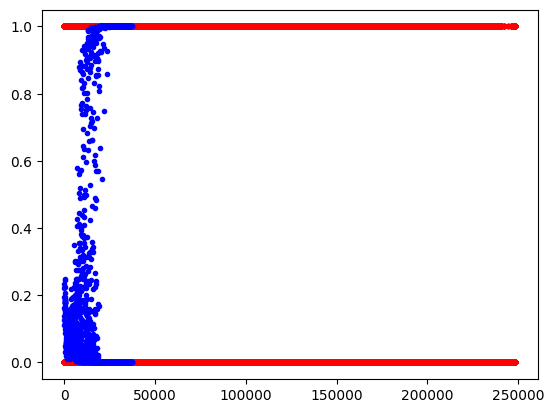

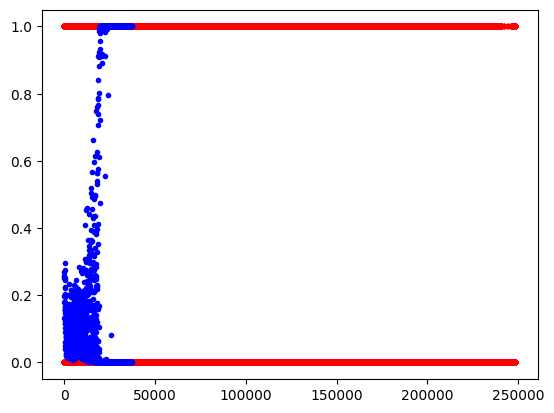

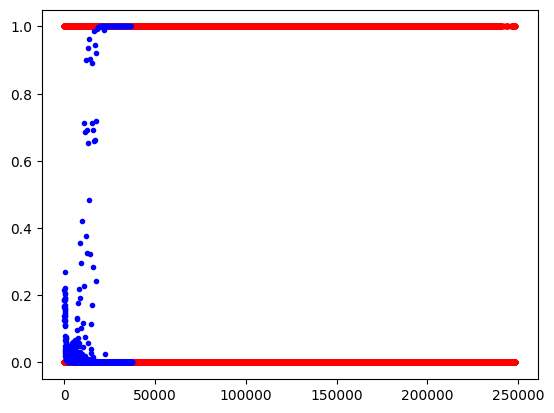

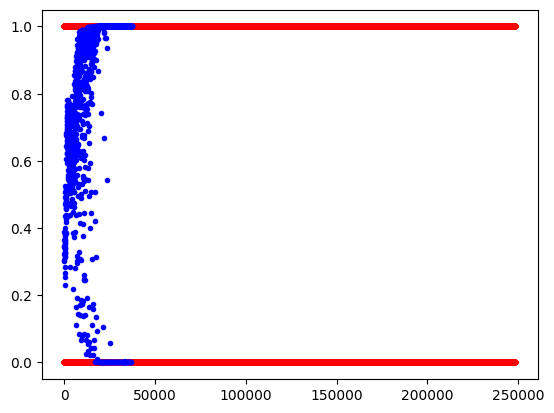

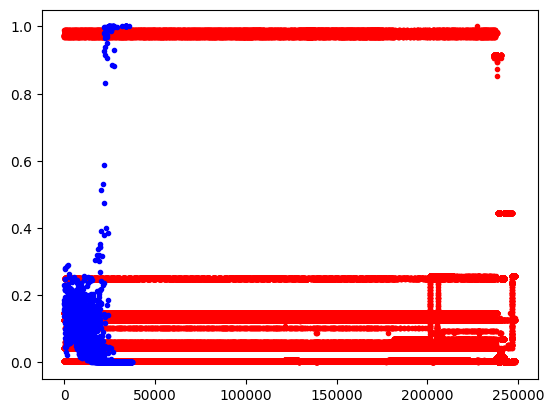

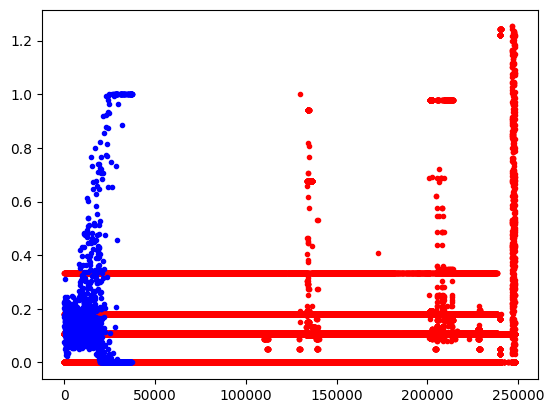

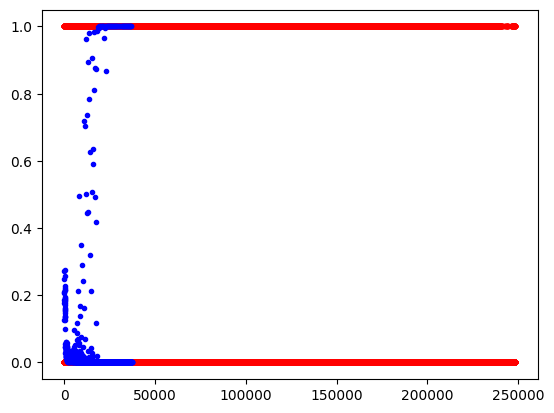

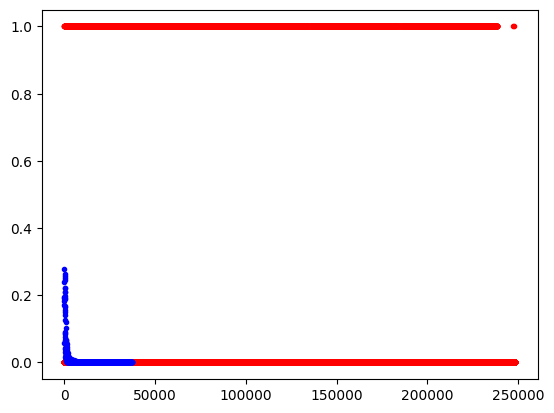

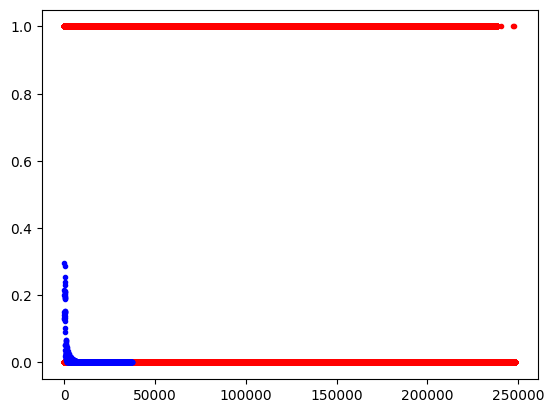

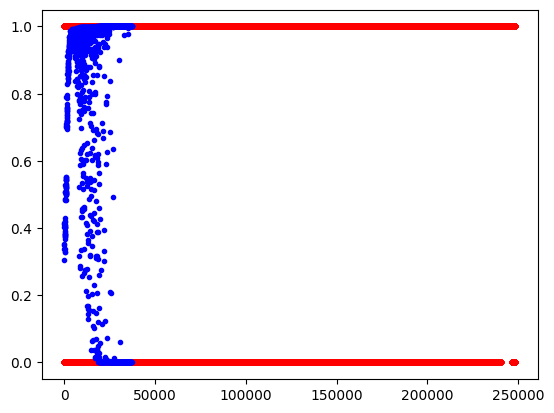

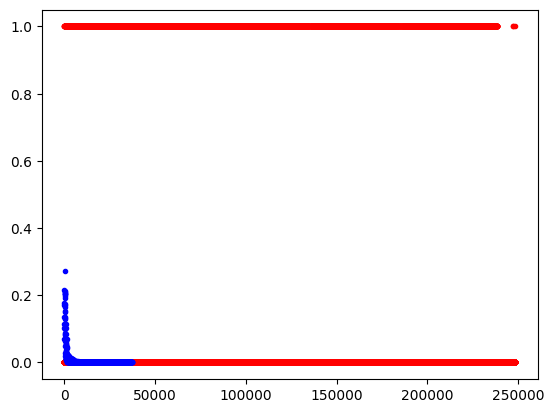

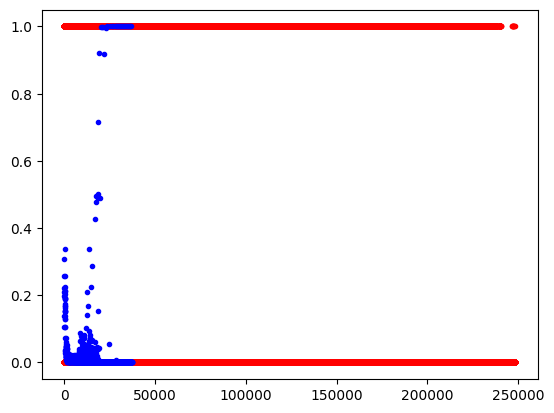

In [150]:
for i in range(21):
    feature = data_labels[i]
    plt.figure(i)
    plt.plot(data_features_test[feature], 'r.')
    plt.plot(np.linspace(0, len(data_features_test[feature]), size), predictions[:,i], '.b')